In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [13]:
# 导入 TorchVision 模块并使用 datasets 模块下载 CIFAR-10 数据
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
# 使用 train=False，获取一个数据集用于验证数据，并在需要时再次下载该数据集
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Using downloaded and verified file: ../data-unversioned/p1ch7/cifar-10-python.tar.gz
Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified


我们提供给 CIFAR10()函数的第 1 个参数是数据的下载位置；第 2 个参数指定我们对训练集
还是验证集感兴趣；第 3 个参数表示如果在第 1 个参数指定的位置找不到数据，我们是否允许
PyTorch 下载数据。

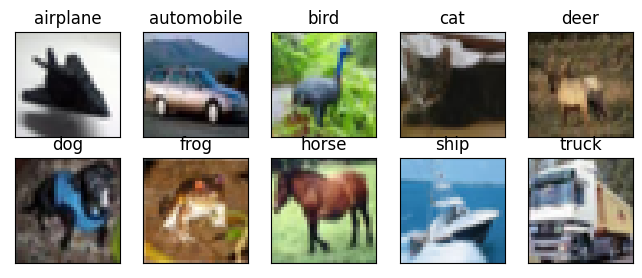

In [16]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

## Dataset类
一个需要实现 2 种函数的对象： `__len__()`和`__getitem__()`，
前者返回数据中的项数，后者返回由样本和与之对应的标签（整数索引）组成的项。 

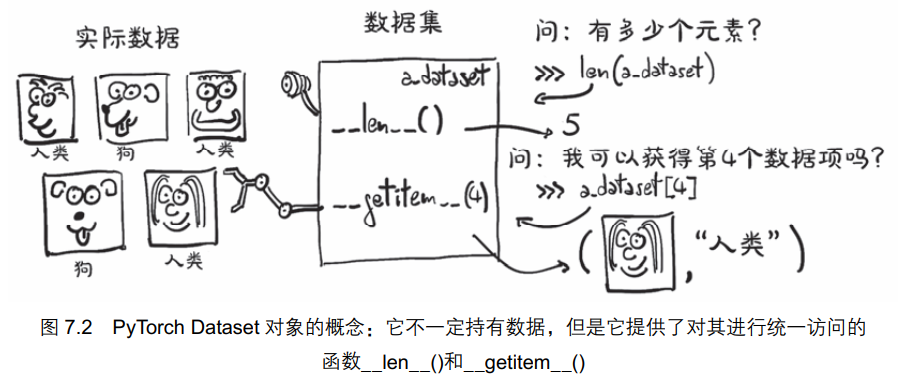

在实践中，当 Python 对象配备了`__len__()`函数时，我们可以将其作为参数传递给 Python 的内置函数 `len()`:

In [14]:
len(cifar10)

50000

类似地，由于数据集配备了`__getitem__()`函数，我们可以使用标准索引对元组和列表进行索引， 以访问单个数据项。 这里， 我们得到一个带有期望输出的 PIL（ Python Imaging Library， Python图像库）图像，即输出值为整数 1，对应图像数据集中的“汽车”：

In [17]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

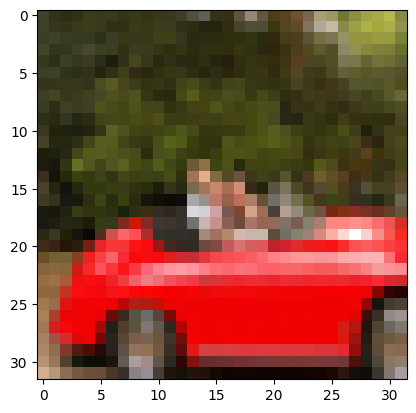

In [18]:
plt.imshow(img)
plt.show()

我们需要一种方法来将 PIL 图像变换为 PyTorch 张量，然后才能使用它做别的事情，因此引入了 `torchvision.transforms` 模块。这个模块定义了一组可组合的、类似函数的对象，它可以作为参数传递到 TorchVision 模块的数据集，诸如 `datasets.CIFAR10(…)`，在数据加载之后，在`__getitem__()`返回之前对数据进行变换。我们可以看到可用对象的列表如下所示：

In [19]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

在这些变换对象中， 我们可以看到 ToTensor 对象，它将 NumPy 数组和 PIL 图像变换为张量。它还将输出张量的尺寸设置为 C×H×W（通道、高度、宽度）

一旦 ToTensor 被实例化，就可以像调用函数一样调用它，以 PIL图像作为参数，返回一个张量作为输出：

In [21]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape,label

(torch.Size([3, 32, 32]), 1)

图像已变换为 3×32×32 的张量，即一个有 3 个通道（ RGB）的 32×32 的图像。注意，标签没有发生任何变化，它仍然是一个整数。

我们可以将变换直接作为参数传递给 dataset.CIFAR10：

In [22]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, 
                                  transform=transforms.ToTensor())

此时，访问数据集的元素将返回一个张量，而不是 PIL 图像：

In [24]:
img_t, _ = tensor_cifar10[99]
type(img_t), img_t.shape, img_t.dtype

(torch.Tensor, torch.Size([3, 32, 32]), torch.float32)

正如预期的那样，形状的第 1 个维度是通道，而标量类型是 float32

原始 PIL 图像中的值为 0～255（每个通道 8 位），而 ToTensor 变换将数据变换为每个通道的32 位浮点数，将值缩小为 0.0～1.0。让我们来验证一下：

In [25]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

我们来验证一下得到的图像是否相同：

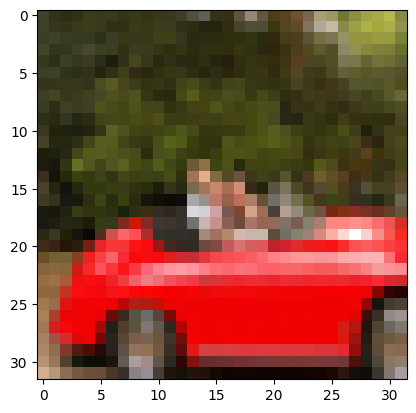

In [26]:
# 使用 permute()将坐标轴的顺序从 C×H×W 更改为 H×W×C，以匹配 Matplotlib 的期望
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## 数据归一化
为了使每个通道的均值为 0、标准差为 1，我们可以应用以下转换来计算数据集中每个通道的平均值和标准差： `v_n[c] = (v[c] - mean[c]) / stdev[c]`。这正是 `transforms.Normalize()`所做的。`mean` 和 `stdev` 的值必须离线计算（它们不是通过变换计算的）。现在让我们计算 CIFAR-10 训练集的平均值和标准差.

让我们将数据集返回的所有张量沿着一个额外的维度进行堆叠：

In [27]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

现在我们可以很容易地计算出每个信道的平均值：

In [31]:
# view(3,−1)保留了 3 个通道，并将剩余的所有维度合并为一个维度，从而计算出适当的尺寸大小。
# 这里我们的 3×32×32 的图像被转换成一个 3×1024 的向量，然后对每个通道的 1024 个元素取平均值
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

计算标准差也是类似的：

In [29]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

有了这些数字，我们就可以初始化 Normalize 变换了：

In [32]:
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

并将其连接到 ToTensor 变换:

In [33]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), 
                             (0.2470, 0.2435, 0.2616))
    ]))

注意，此时，从数据集绘制的图像不能为我们提供实际图像的真实表示：

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


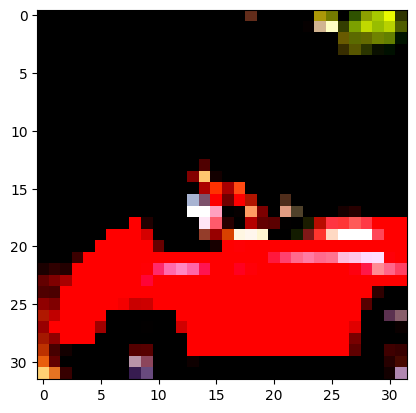

In [34]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))
plt.show()

我们得到的重新归一化的红色汽车如上图所示。这是因为归一化对 RGB 超出 0.0～1.0 的数据进行了转化，并且调整了通道的总体大小，所有的数据仍然存在，只是 Matplotlib 将其渲染为黑色。